# Laboratorio # 3

- Juan Luis Solórzano
- Diego Alonzo
- Arturo Argueta

In [6]:
import cv2
import numpy as np
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.pyplot as plt

## 1. Preprocesamiento de la imagen

In [7]:
def preprocess_image(image: np.ndarray, k: int, output_dtype=np.uint8) -> np.ndarray:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if k < 1:
        raise ValueError("El valor de k debe ser mayor o igual a 1.")
    
    # Redimensionar la imagen al tamaño (128k, 64k)
    new_size = (int(128 * k), int(64 * k))
    resized_image = resize(image, new_size, anti_aliasing=True)
    
    # Convertir a formato de salida
    if output_dtype == np.uint8:
        resized_image = (resized_image * 255).astype(np.uint8)
    elif output_dtype == np.float32:
        resized_image = resized_image.astype(np.float32)
    else:
        raise ValueError("Tipo de salida no soportado. Use np.uint8 o np.float32.")
    
    return resized_image

In [31]:
# Ejemplo de uso:
image = cv2.imread('walk.jpg')

processed_image = preprocess_image(image, k=3)

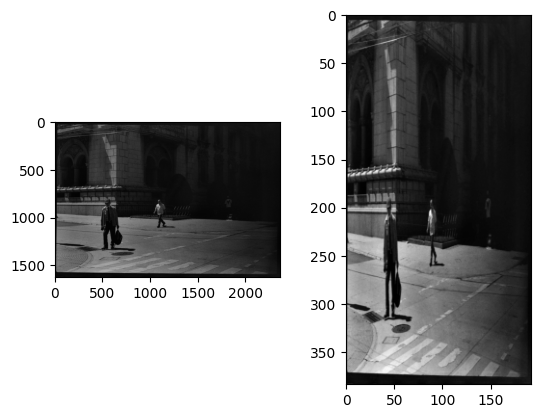

In [32]:
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(processed_image, cmap="gray")

## 2. Prewitt o Sobel

In [33]:
def compute_gradient(image: np.ndarray, method: str = 'sobel'):
    # Convertir a float32 para evitar overflow
    image = image.astype(np.float32)
    
    if method.lower() == 'sobel':
        kernel_x = np.array([[-1, -2, -1], 
                             [ 0,  0,  0],
                             [ 1,  2,  1]])
        kernel_y = np.array([[-1, 0, 1], 
                             [-2, 0, 2], 
                             [-1, 0, 1]])
    elif method.lower() == 'prewitt':
        kernel_x = np.array([[-1, -1, -1], 
                             [ 0,  0,  0], 
                             [ 1,  1,  1]])
        kernel_y = np.array([[-1, 0, 1], 
                             [-1, 0, 1], 
                             [-1, 0, 1]])
    else:
        raise ValueError("Método no válido. Usa 'sobel' o 'prewitt'")
    
    # Invertir kernels para OpenCV (opcional, depende de tu convención)
    kernel_x = np.flipud(kernel_x)
    kernel_y = np.flipud(kernel_y)
    
    # Aplicar padding
    padded_image = cv2.copyMakeBorder(image, 1, 1, 1, 1, cv2.BORDER_REPLICATE)
    
    # Aplicar filtros
    Gx = cv2.filter2D(padded_image, -1, kernel_x)[1:-1, 1:-1]
    Gy = cv2.filter2D(padded_image, -1, kernel_y)[1:-1, 1:-1]
    
    # Calcular magnitud y dirección
    magnitude = np.sqrt(Gx**2 + Gy**2)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    
    theta = np.arctan2(Gy, Gx) * (180 / np.pi) % 180  # Modulo 180
    
    return magnitude.astype(np.uint8), theta

In [34]:
image_sobel_mu, image_sobel_theta = compute_gradient(processed_image, "sobel")
image_prewitt_mu, image_prewitt_theta = compute_gradient(processed_image, "prewitt")

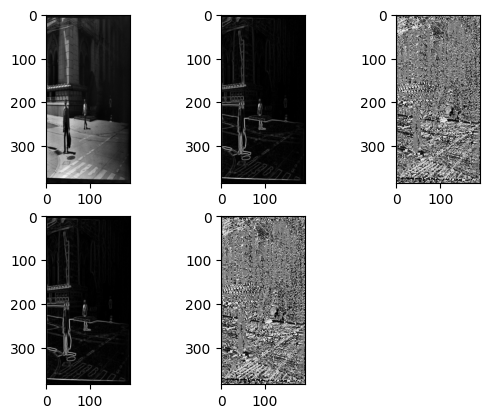

In [35]:
plt.subplot(2, 3, 1)
plt.imshow(processed_image,cmap="gray")
plt.subplot(2, 3, 2)
plt.imshow(image_sobel_mu, cmap="gray")
plt.subplot(2, 3, 3)
plt.imshow(image_sobel_theta, cmap="gray")
plt.subplot(2, 3, 4)
plt.imshow(image_prewitt_mu, cmap="gray")
plt.subplot(2, 3, 5)
plt.imshow(image_prewitt_theta, cmap="gray")

## 3. Stack de bloques

In [36]:
def extract_blocks(mu, theta, block_size):
    stride = block_size // 2
    height, width = mu.shape

    #evitar desbordamiento
    M = (height - block_size) // stride - 1
    N = (width - block_size) // stride - 1
    
    blocks_mu = np.zeros((M, N, block_size, block_size), dtype=mu.dtype)
    blocks_theta = np.zeros((M, N, block_size, block_size), dtype=theta.dtype)
    
    for i in range(M):
        for j in range(N):
            y = i * stride
            x = j * stride
            if y + block_size <= height and x + block_size <= width:
                blocks_mu[i, j] = mu[y:y+block_size, x:x+block_size]
                blocks_theta[i, j] = theta[y:y+block_size, x:x+block_size]
    
    return blocks_mu, blocks_theta


In [37]:
BLOCK_SIZE= 32

In [38]:
array_sobel_mu, array_sobel_theta = extract_blocks(image_sobel_mu, image_sobel_theta, BLOCK_SIZE)
array_prewitt_mu, array_prewitt_theta = extract_blocks(image_prewitt_mu, image_prewitt_theta, BLOCK_SIZE)

In [39]:
array_sobel_mu.shape

(21, 9, 32, 32)

## 4. histograma de gradientes

In [40]:
def compute_histograms(blocks_mu, blocks_theta, n_bins):
    M, N, h, w = blocks_mu.shape
    H = np.zeros((M, N, n_bins), dtype=np.float32)
    
    bin_width = 180 / n_bins  # Asumiendo ángulos en [0, 180)

    for i in range(M):
        for j in range(N):
            hist = np.zeros(n_bins, dtype=np.float32)
            for y in range(h):
                for x in range(w):
                    magnitude = blocks_mu[i, j, y, x]
                    angle = blocks_theta[i, j, y, x] % 180  # Asegura que esté entre 0 y 180
                    
                    # Índices de los bins adyacentes
                    bin_idx = angle / bin_width
                    b1 = int(np.floor(bin_idx)) % n_bins
                    b2 = (b1 + 1) % n_bins
                    
                    # Pesos bilineales
                    w2 = bin_idx - np.floor(bin_idx)
                    w1 = 1 - w2
                    
                    # Votos ponderados
                    hist[b1] += w1 * magnitude
                    hist[b2] += w2 * magnitude
            
            # Normalización euclidiana
            norm = np.linalg.norm(hist) + 1e-6
            H[i, j, :] = hist / norm
    
    return H


In [41]:
n_bins = 12# o cualquier valor que estés usando

In [42]:
hist_sobel = compute_histograms(array_sobel_mu, array_sobel_theta, n_bins)
hist_prewitt = compute_histograms(array_prewitt_mu, array_prewitt_theta, n_bins)

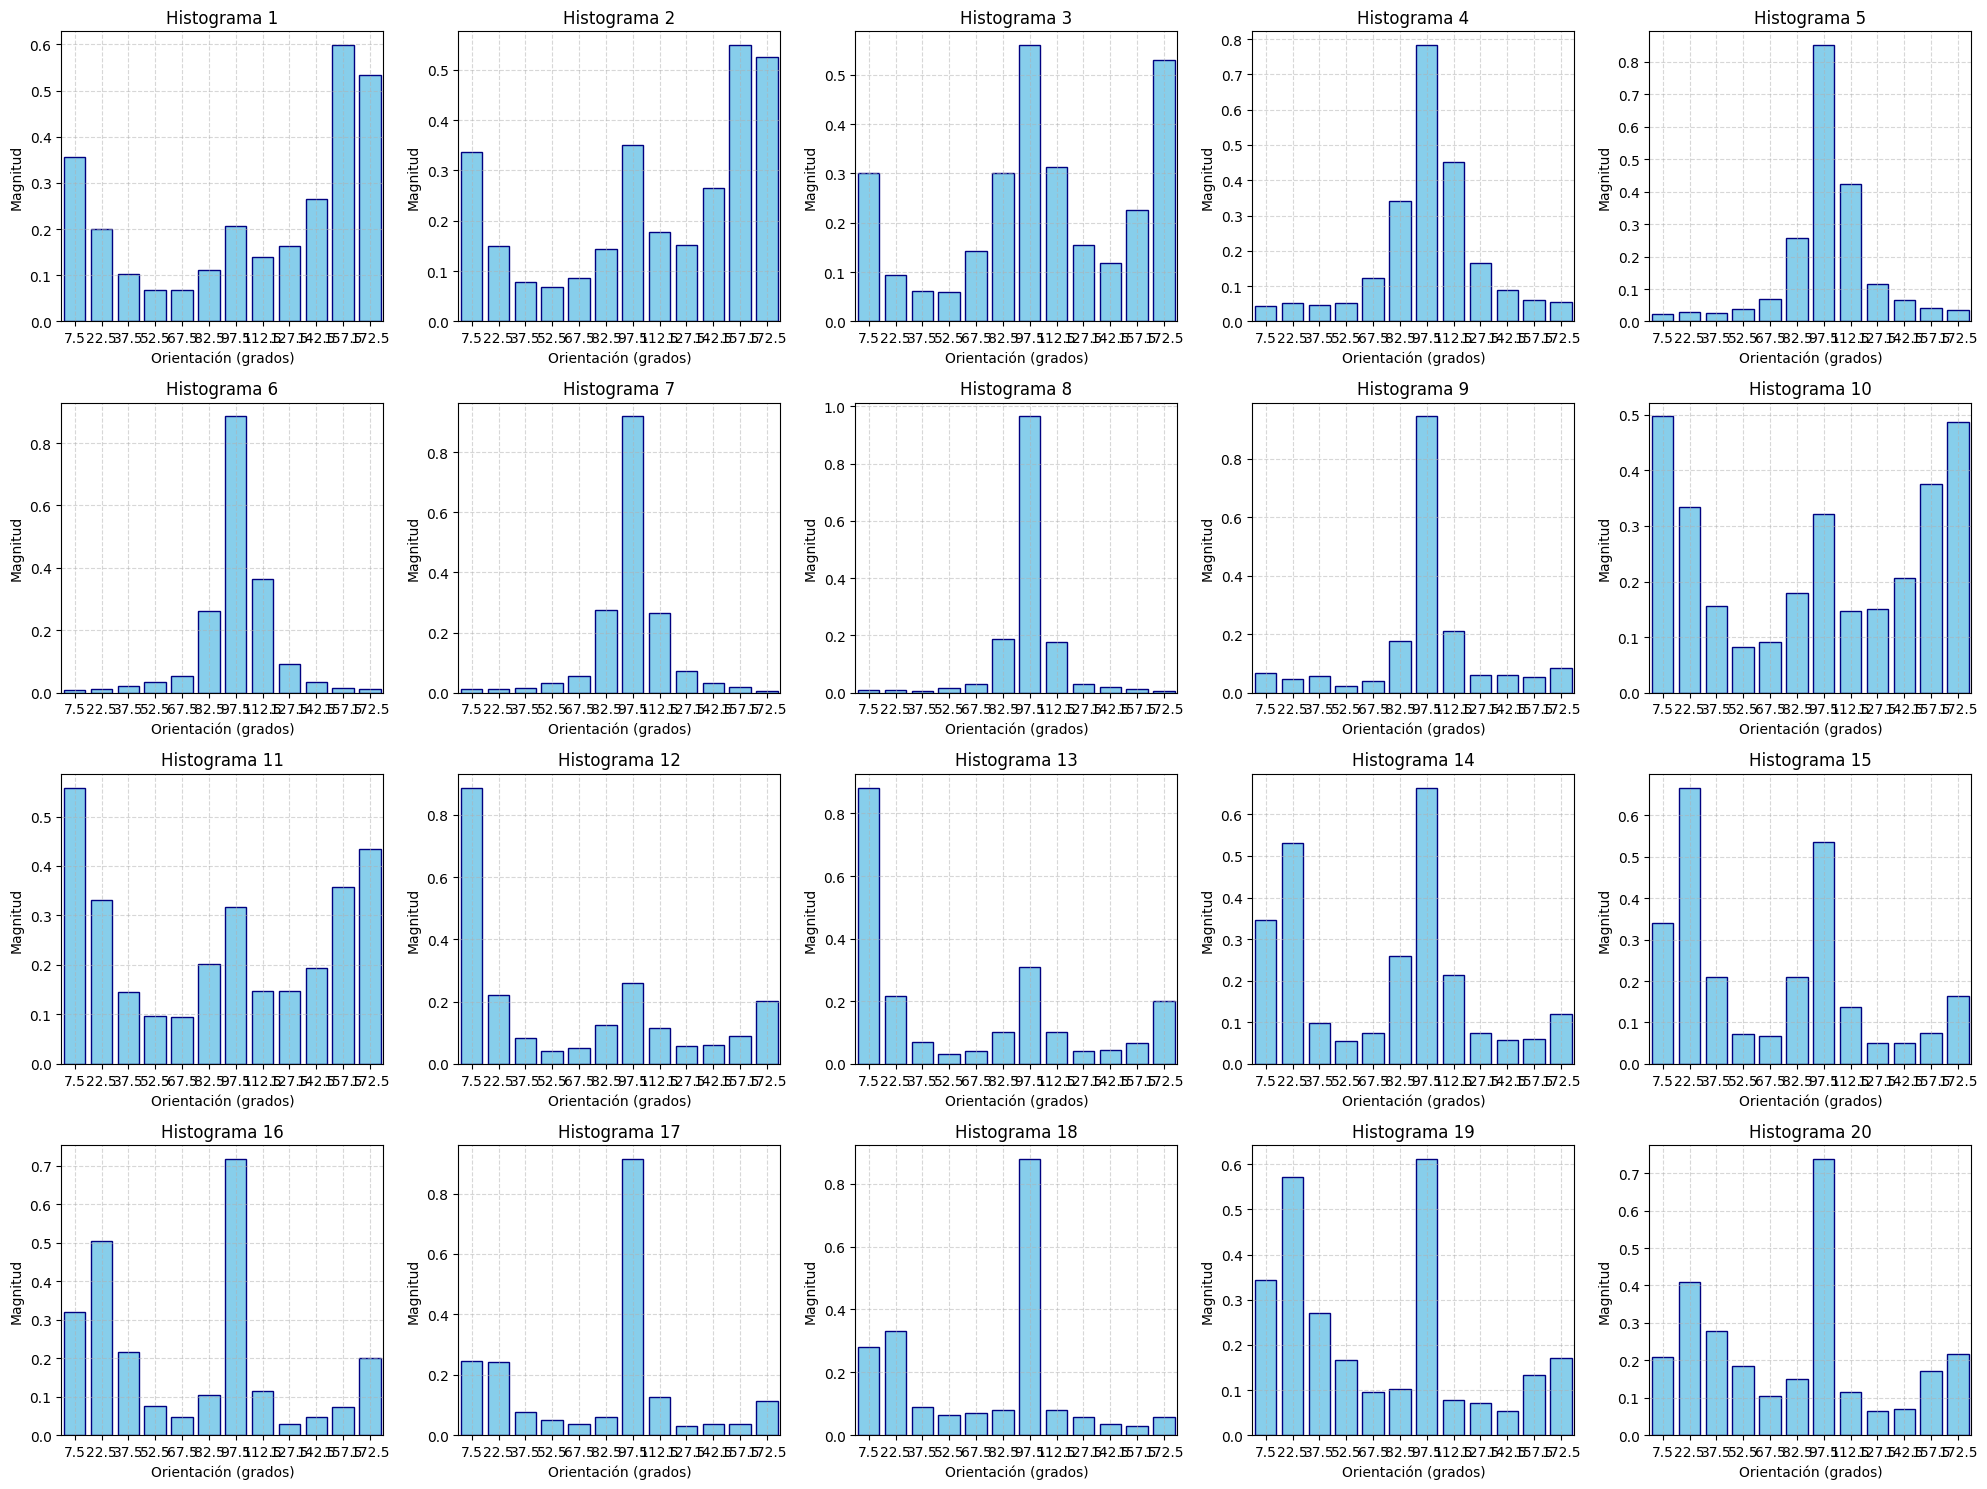

In [43]:

b = [(180./n_bins)*(i+.5) for i in range(n_bins)]  

#
fig, axes = plt.subplots(4, 5, figsize=(20, 15))
axes = axes.flatten()  

H = hist_sobel  


num_histograms = min(20, H.shape[0])  # Mostrar hasta 20 histogramas

for i in range(num_histograms):
   
    hist_data = H[i, 0, :]
    
    # Graficar el histograma
    axes[i].bar(b, hist_data, width=(180/n_bins)*0.8, align='center', color='skyblue', edgecolor='navy')
    axes[i].set_title(f'Histograma {i+1}')
    axes[i].set_xlabel('Orientación (grados)')
    axes[i].set_ylabel('Magnitud')
    axes[i].set_xticks(b)
    axes[i].grid(True, linestyle='--', alpha=0.5)
    axes[i].set_xlim(0, 180)  # Asegurar que el eje x cubra todo el rango

# Ocultar ejes vacíos si mostramos menos de 20 histogramas
for j in range(num_histograms, 20):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## 5. Visualización de histogramas por bloque

In [44]:
def visualize_block_histogram(hist, block_size, n_bins):
    image = np.zeros((block_size, block_size), dtype=np.uint8)
    center = (block_size // 2, block_size // 2)
    bin_width = 180 / n_bins

    for i in range(n_bins):
        angle = i * bin_width + bin_width / 2
        radians = np.deg2rad(angle)

        dx = int(np.cos(radians) * (block_size // 2 - 1))
        dy = int(np.sin(radians) * (block_size // 2 - 1))
        
        x1 = center[0] - dx
        y1 = center[1] - dy
        x2 = center[0] + dx
        y2 = center[1] + dy
        
        magnitude = hist[i]
        intensity = int(np.clip(magnitude * 255, 0, 255))
        
        cv2.line(image, (x1, y1), (x2, y2), intensity, 1, lineType=cv2.LINE_AA)

    return image


In [45]:
def visualize_all_blocks(histograms, block_size):
    M, N, n_bins = histograms.shape
    height = M * block_size
    width = N * block_size
    vis_image = np.zeros((height, width), dtype=np.uint8)

    for i in range(M):
        for j in range(N):
            block_hist = histograms[i, j]
            block_img = visualize_block_histogram(block_hist, block_size, n_bins)
            y, x = i * block_size, j * block_size
            vis_image[y:y+block_size, x:x+block_size] = block_img
    
    return vis_image


In [46]:
def show_image_with_directions(original_image, direction_image):
    # Asegúrate de que ambas tengan mismo tamaño o redimensiona si es necesario
    if len(original_image.shape) == 3:
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    direction_image_resized = cv2.resize(direction_image, (original_image.shape[1], original_image.shape[0]))

    combined = np.hstack((original_image, direction_image_resized))

    plt.figure(figsize=(15, 10))
    plt.imshow(combined, cmap='gray')
    plt.title('Original Image (left) and Block Directions (right)')
    plt.axis('off')
    plt.show()

In [47]:
direction_image = visualize_all_blocks(hist_sobel, BLOCK_SIZE)


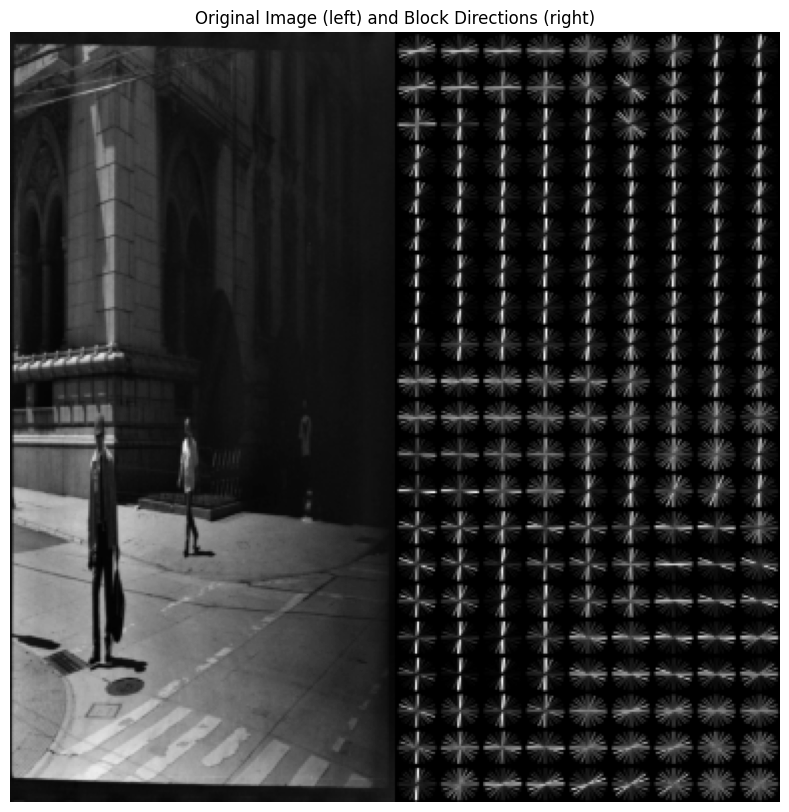

In [48]:
show_image_with_directions(processed_image, direction_image)

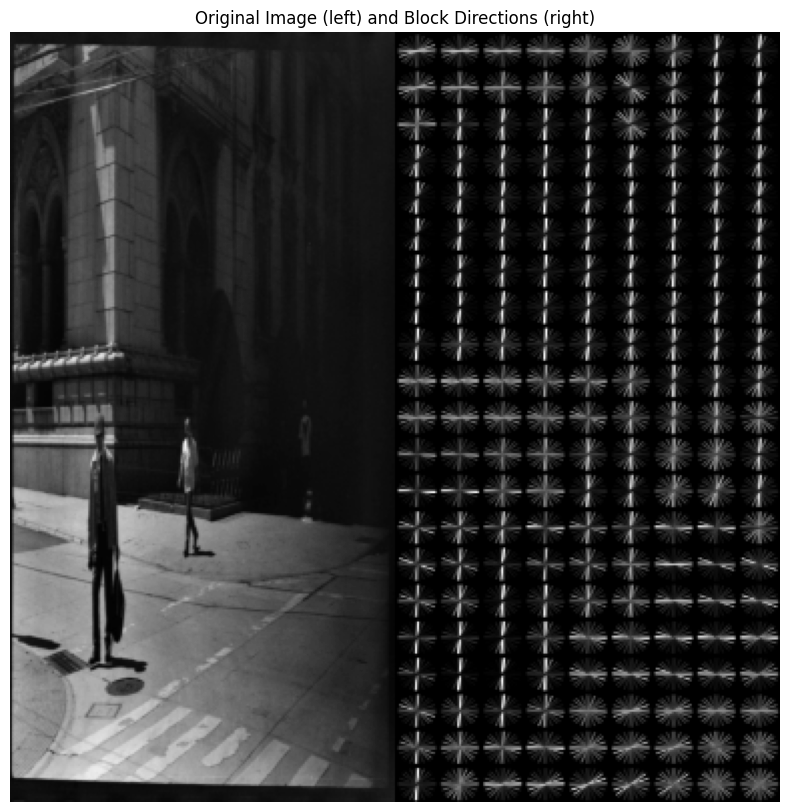

In [49]:
direction_image = visualize_all_blocks(hist_prewitt, BLOCK_SIZE)
show_image_with_directions(processed_image, direction_image)


## 6 usar scikit HOG

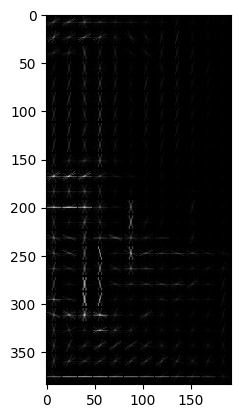

In [54]:
from skimage.feature import hog
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
fd, hogI = hog(processed_image, orientations=9, pixels_per_cell=(16,16), cells_per_block=(2,2), visualize=True)
plt.figure()
plt.imshow(hogI, cmap = 'gray')
plt.show()

## 7 Detección de personas

In [51]:

def person_detector(I):
    hog2 = cv2.HOGDescriptor()
    hog2.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
    
    locations , confidence = hog2.detectMultiScale(I, winStride=(8, 8), padding=(8, 8), scale= 1.04 )
    for (x, y, w, h) in locations:
        cv2.rectangle(I, (x, y), (x + w, y + h), (0, 0, 255), 5)
    I_rgb = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(20,10))
    plt.imshow(I_rgb)
    plt.axis('off')
    plt.show()




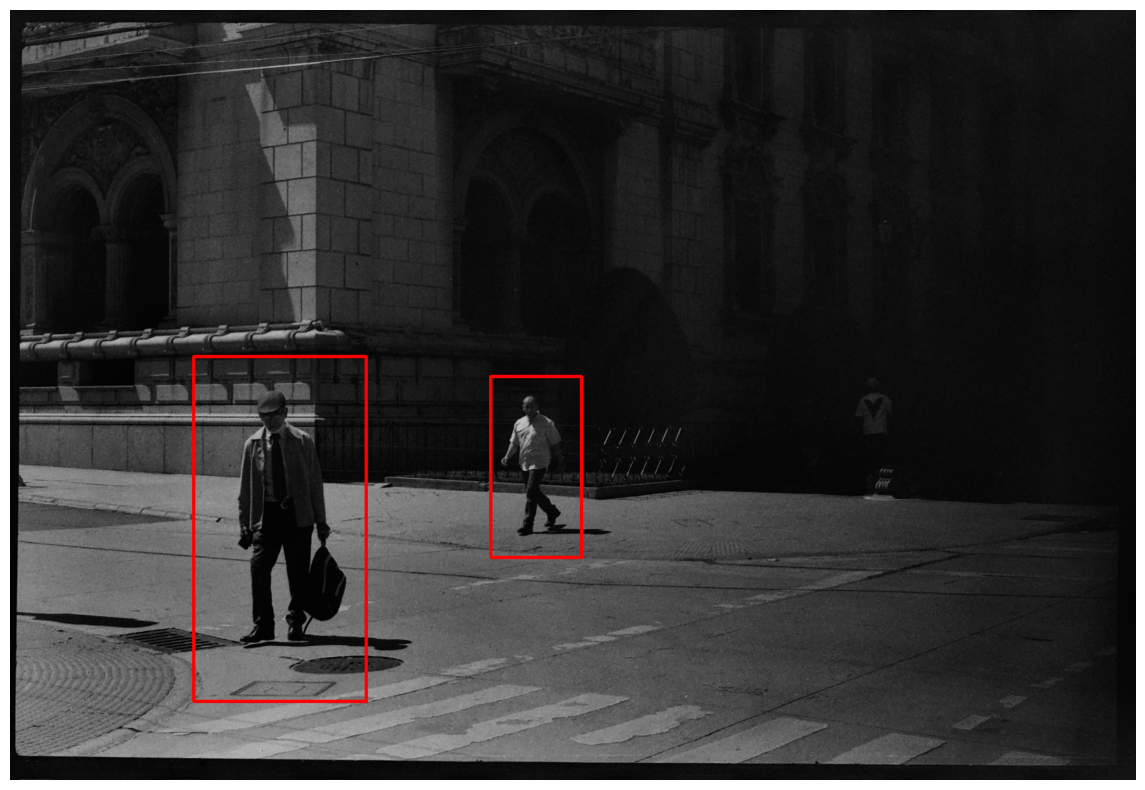

In [53]:
person_detector(image)